# AutoMM for Object Detection - High Performance Finetune on COCO Format Dataset
:label:`sec_automm_detection_high_ft_coco`

[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/autogluon/neurips2022-autogluon-workshop/blob/main/notebooks/multimodal/detection_high_performance_finetune_coco.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/autogluon/neurips2022-autogluon-workshop/blob/main/notebooks/multimodal/detection_high_performance_finetune_coco.ipynb)

![Pothole Dataset](https://automl-mm-bench.s3.amazonaws.com/object_detection/example_image/pothole144_gt.jpg)
:width:`500px`

In this section, our goal is to fast finetune and evaluate a pretrained model 
on [Pothole dataset](https://www.kaggle.com/datasets/andrewmvd/pothole-detection) in COCO format.
Pothole is a single object, i.e. `pothole`, detection dataset, containing 665 images with bounding box annotations
for the creation of detection models and can work as POC/POV for the maintenance of roads.
See :ref:`sec_automm_detection_prepare_voc` for how to prepare Pothole dataset.

To start, let's install autogluon and import MultiModalPredictor. Note that you will **have to restart the runtime** if you are using Google Colab / SageMaker Studio Lab.

In [1]:
!pip install -U -q autogluon==0.6.1b20221128
# Uncomment the following if you are using SageMaker Studio Lab
#!conda install -q -y glib
#!pip uninstall -y opencv-python
#!pip install -U opencv-python-headless

# Make sure `mmcv-full` and `mmdet` are installed:
!mim install -q mmcv-full
!pip install -q mmdet

In [2]:
from autogluon.multimodal import MultiModalPredictor

And also import some other packages that will be used in this tutorial:

In [3]:
import os
import time

from autogluon.core.utils.loaders import load_zip

We have the sample dataset ready in the cloud. Let's download it:

In [4]:
zip_file = "https://automl-mm-bench.s3.amazonaws.com/object_detection/dataset/pothole.zip"
download_dir = "./pothole"

load_zip.unzip(zip_file, unzip_dir=download_dir)
data_dir = os.path.join(download_dir, "pothole")
train_path = os.path.join(data_dir, "Annotations", "usersplit_train_cocoformat.json")
val_path = os.path.join(data_dir, "Annotations", "usersplit_val_cocoformat.json")
test_path = os.path.join(data_dir, "Annotations", "usersplit_test_cocoformat.json")

While using COCO format dataset, the input is the json annotation file of the dataset split.
In this example, `usersplit_train_cocoformat.json` is the annotation file of the train split.
`usersplit_val_cocoformat.json` is the annotation file of the validation split.
And `usersplit_test_cocoformat.json` is the annotation file of the test split.

We select the VFNet with ResNet-50 as backbone, Feature Pyramid Network (FPN) as neck,
and input resolution is 640x640, pretrained on COCO dataset.
*(The neck of the object detector refers to the additional layers existing between the backbone and the head. 
Their role is to collect feature maps from different stages.)*
With this setting, it sacrifices training and inference time,
and also requires much more GPU memory,
but the performance is high. 

We use `val_metric = map`, i.e., mean average precision in COCO standard as our validation metric.
In previous section :ref:`sec_automm_detection_fast_ft_coco`,
we did not specify the validation metric and by default the validation loss is used as validation metric.
Using validation loss is much faster but using mean average precision gives the best performance.

And we use all the GPUs (if any):

In [5]:
checkpoint_name = "vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco"
num_gpus = -1  # use all GPUs
val_metric = "map"

We create the MultiModalPredictor with selected checkpoint name, val_metric, and number of GPUs.
We need to specify the problem_type to `"object_detection"`,
and also provide a `sample_data_path` for the predictor to infer the catgories of the dataset.
Here we provide the `train_path`, and it also works using any other split of this dataset.

In [6]:
predictor = MultiModalPredictor(
    hyperparameters={
        "model.mmdet_image.checkpoint_name": checkpoint_name,
        "env.num_gpus": num_gpus,
        "optimization.val_metric": val_metric,
    },
    problem_type="object_detection",
    sample_data_path=train_path,
)

/usr/local/lib/python3.7/dist-packages/autogluon/multimodal/predictor.py:433: UserWarning: Running object detection. Make sure that you have installed mmdet and mmcv-full, by running 'mim install mmcv-full' and 'pip install mmdet'
  "Running object detection. Make sure that you have installed mmdet and mmcv-full, "


processing vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco...
vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-6879c318.pth exists in /content
Successfully dumped vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco.py to /content
load checkpoint from local path: vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-6879c318.pth
The model and loaded state dict do not match exactly

size mismatch for bbox_head.vfnet_cls.weight: copying a param with shape torch.Size([80, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 256, 3, 3]).
size mismatch for bbox_head.vfnet_cls.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([1]).


We used `1e-4` for Yolo V3 in previous tutorial, 
but set the learning rate to be `5e-6` here, 
because larger model always prefers smaller learning rate.
Note that we use a two-stage learning rate option during finetuning by default,
and the model head will have 100x learning rate.
Using a two-stage learning rate with high learning rate only on head layers makes
the model converge faster during finetuning. It usually gives better performance as well,
especially on small datasets with hundreds or thousands of images.
We also set the batch_size to be 2, because this model is too huge to run with larger batch size.
We also compute the time of the fit process here for better understanding the speed.
We only set the number of epochs to be 1 for a quick demonstration, 
and to seriously finetune the model on this dataset we will need to set this to 20 or more.

In [7]:
import time
start = time.time()
predictor.fit(
    train_path,
    hyperparameters={
        "optimization.learning_rate": 5e-6, # we use two stage and detection head has 100x lr
        "optimization.max_epochs": 1,
        "env.per_gpu_batch_size": 2,  # decrease it when model is large
    },
)
end = time.time()

INFO:automm:Using default root folder: ./pothole/pothole/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


INFO:pytorch_lightning.utilities.seed:Global seed set to 123
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | model             | MMDetAutoModelForObjectDetection | 33.7 M
1 | validation_metric | MeanAveragePrecision             | 0     
-----------------------------------------------------------------------
33.5 M    Trainable params
225 K     Non-trainable params
33.7 M    Total params
134.821   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1: 'val_map' reached 0.00001 (best 0.00001), saving model to '/content/AutogluonModels/ag-20221128_063829/epoch=0-step=1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 3: 'val_map' reached 0.00002 (best 0.00002), saving model to '/content/AutogluonModels/ag-20221128_063829/epoch=0-step=3.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
INFO:automm:Models and intermediate outputs are saved to /content/AutogluonModels/ag-20221128_063829 


Print out the time and we can see that it takes a long time even for one epoch.

In [8]:
print("This finetuning takes %.2f seconds." % (end - start))

This finetuning takes 283.40 seconds.


To get a model with reasonable performance, you will need to finetune the model with more epochs.
We set `max_epochs` to 50 and trained a model offline. And we uploaded it to AWS S3. 
To load and check the result:

In [9]:
# Load Trained Predictor from S3
zip_file = "https://automl-mm-bench.s3.amazonaws.com/object_detection/checkpoints/pothole_AP50_718.zip"
download_dir = "./pothole_AP50_718"
load_zip.unzip(zip_file, unzip_dir=download_dir)
better_predictor = MultiModalPredictor.load("./pothole_AP50_718/AutogluonModels/ag-20221123_021130")
better_predictor.set_num_gpus(1)

# Evaluate new predictor
better_predictor.evaluate(test_path)

processing vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco...
vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco_20201027pth-6879c318.pth exists in /content
Successfully dumped vfnet_r50_fpn_mdconv_c3-c5_mstrain_2x_coco.py to /content


INFO:automm:Load pretrained checkpoint: /content/pothole_AP50_718/AutogluonModels/ag-20221123_021130/model.ckpt
INFO:automm:Using default root folder: ./pothole/pothole/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Predicting: 0it [00:00, ?it/s]

saving file at /content/AutogluonModels/ag-20221128_064343/object_detection_result_cache.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.717
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.481
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.255
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=  

{'map': 0.4493231102621059}

We can get the prediction on test set:

In [10]:
pred = better_predictor.predict(test_path)

INFO:automm:Using default root folder: ./pothole/pothole/Annotations/... Specify `root=...` if you feel it is wrong...


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Predicting: 0it [00:00, ?it/s]

Let's also visualize the prediction result:

INFO:automm:Saved visualizations to ./


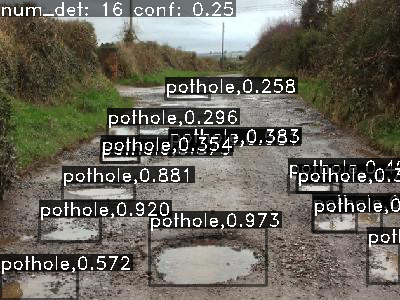

In [11]:
from autogluon.multimodal.utils import visualize_detection
conf_threshold = 0.25  # Specify a confidence threshold to filter out unwanted boxes
visualization_result_dir = "./"  # Use the pwd as result dir to save the visualized image
visualized = visualize_detection(
    pred=pred[12:13],
    detection_classes=predictor.get_predictor_classes(),
    conf_threshold=conf_threshold,
    visualization_result_dir=visualization_result_dir,
)
from PIL import Image
from IPython.display import display
img = Image.fromarray(visualized[0][:, :, ::-1], 'RGB')
display(img)

Under this high performance finetune setting, it took a long time to train but reached `mAP = 0.450, mAP50 = 0.718`!
For how to finetune faster,
see :ref:`sec_automm_detection_fast_ft_coco`, where we finetuned a YOLOv3 model with lower
performance but much faster.

### Other Examples

You may go to [AutoMM Examples](https://github.com/awslabs/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

### Customization
To learn how to customize AutoMM, please refer to [customization tutorial](https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html)

### Citation

```
@article{DBLP:journals/corr/abs-2008-13367,
  author    = {Haoyang Zhang and
               Ying Wang and
               Feras Dayoub and
               Niko S{\"{u}}nderhauf},
  title     = {VarifocalNet: An IoU-aware Dense Object Detector},
  journal   = {CoRR},
  volume    = {abs/2008.13367},
  year      = {2020},
  url       = {https://arxiv.org/abs/2008.13367},
  eprinttype = {arXiv},
  eprint    = {2008.13367},
  timestamp = {Wed, 16 Sep 2020 11:20:03 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/abs-2008-13367.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}
```